In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from sklearn.utils import shuffle
%matplotlib inline
pd.options.display.max_columns = 100

# Vote History Model
This model will primarily focus on predicting voting behaviour based on previous voting behavior. Specifically, it will look at the percent that a member votes with their party in a current session (up to the vote in question) for:
1. All votes
2. By bill type
3. By committee type

## Feature Construction

In [2]:
def get_full_set():
    for dataset in ['train','dev','test']:
        df = pd.read_csv('../data/model/' + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes
df_votes = get_full_set()
df_votes['s_roll'] = df_votes.session * 10000 + df_votes.roll_call
df_votes['voted'] = 1
df_votes.sort_values(['congress', 's_roll'], inplace=True)
df_votes.set_index('full_set_id', inplace=True)

### Vote With Party %
#### Overall

In [3]:
gb = ['congress','member_id']
df_party = pd.concat([df_votes[gb], df_votes.groupby(gb).shift()], axis = 1).groupby(gb).cumsum()[['broke_from_party','voted']]
df_party['broke_pct'] = df_party.broke_from_party / df_party.voted
df_party.columns = ["party_all_" + x for x in df_party.columns]
df_party.tail()

,party_all_broke_from_party,party_all_voted,party_all_broke_pct
full_set_id,,,
1933669,0.0,222.0,0.000000
1933751,1.0,222.0,0.004505
1933912,5.0,215.0,0.023256
1933633,0.0,210.0,0.000000
1933681,0.0,220.0,0.000000


In [5]:
df_party.party_all_broke_pct.describe() * 100

count    1.642928e+08
mean     4.923343e+00
std      5.594616e+00
min      0.000000e+00
25%      9.411765e-01
50%      3.370787e+00
75%      7.103825e+00
max      1.000000e+02
Name: party_all_broke_pct, dtype: float64

#### By Bill Type

In [4]:
# standardize bill type across chambers
df_votes['bill_type'] = df_votes.bill_id.str.replace('[0-9]', '').str.replace("-", "")
recode = {"hres": 'res', 'hconres': "conres", 'hjres': 'jres', 
          'sres': 'res', 'sconres':'conres', 'sjres': 'jres', 
          "s":'bill', 'hr': 'bill',
          "": "other", 'motion': "other", 'treatydoc':'other'}
df_votes['bill_type'] = df_votes.bill_type.replace(recode)
df_votes.bill_type.value_counts()

bill      1109121
res        438603
jres        62846
conres      36358
other        1935
Name: bill_type, dtype: int64

In [5]:
gb = ['congress','bill_type','member_id']
df = pd.concat([df_votes[gb], df_votes.groupby(gb).shift()], axis = 1).groupby(gb).cumsum()[['broke_from_party','voted']]
df['broke_pct'] = df.broke_from_party / df.voted
df.columns = ["party_bill_" + x for x in df.columns]
df.tail()

,party_bill_broke_from_party,party_bill_voted,party_bill_broke_pct
full_set_id,,,
1933669,0.0,139.0,0.000000
1933751,1.0,139.0,0.007194
1933912,5.0,135.0,0.037037
1933633,0.0,131.0,0.000000
1933681,0.0,138.0,0.000000


In [8]:
df.party_bill_broke_pct.describe() * 100

count    1.624265e+08
mean     4.979666e+00
std      7.464225e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.439024e+00
75%      7.058824e+00
max      1.000000e+02
Name: party_bill_broke_pct, dtype: float64

In [6]:
df_party = pd.concat([df_party, df], axis = 1)

#### By Committee

In [7]:
# pull in committees associated with each bill
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_bills.drop_duplicates(subset = ['bill_id'], inplace = True)
df_bills = df_bills.dropna(subset=['committee_codes'])[['bill_id', 'com_codes_fuzzy2']]
def fix_eval(row):
    """Combination of different API pulls from different people resulted in lists being inconsistenly stored"""
    try:
        new = eval(row)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        row = row.replace('[', "")
        row = row.replace(']', "")
        new = row.split(', ')
    except:
        new = row
    return new

df_bills['com_codes_fuzzy2'] = df_bills.com_codes_fuzzy2.apply(fix_eval)
df_bills.rename(columns={'com_codes_fuzzy2': 'committee_codes'}, inplace = True)

# dummy code committees
committee_dummies = pd.get_dummies(df_bills.committee_codes.apply(pd.Series).stack()).sum(level=0)
committee_dummies.columns = ["com_" + x for x in committee_dummies.columns]
df_bills = pd.concat([df_bills, committee_dummies], axis = 1)
df_votes = pd.merge(df_votes.reset_index(), df_bills, how = 'left', on = 'bill_id')
df_votes.set_index('full_set_id', inplace = True)

In [19]:
# get running vote average for all committees
# this will take a couple of minutes to run
for i, committee in enumerate(committee_dummies.columns):
    gb = ['congress',committee,'member_id']
    df = pd.concat([df_votes[gb], df_votes.groupby(gb).shift()], axis = 1).groupby(gb).cumsum()[['broke_from_party','voted']]
    df.columns = [committee + "_" + x for x in df.columns]
    if i == 0:
        df_master = df
    else:
        df_master = pd.concat([df_master, df], axis = 1)
df_master['committees'] = df_votes.committee_codes
df_master = pd.concat([df_master, 
                       df_party[['party_bill_voted', 'party_bill_broke_from_party']]], 
                      axis = 1)

In [20]:
df_master.tail()

,com_HLIG_broke_from_party,com_HLIG_voted,com_HSAG_broke_from_party,com_HSAG_voted,com_HSAP_broke_from_party,com_HSAP_voted,com_HSAS_broke_from_party,com_HSAS_voted,com_HSBA_broke_from_party,com_HSBA_voted,com_HSBU_broke_from_party,com_HSBU_voted,com_HSED_broke_from_party,com_HSED_voted,com_HSFA_broke_from_party,com_HSFA_voted,com_HSGO_broke_from_party,com_HSGO_voted,com_HSHA_broke_from_party,com_HSHA_voted,com_HSHM_broke_from_party,com_HSHM_voted,com_HSIF_broke_from_party,com_HSIF_voted,com_HSIG_broke_from_party,com_HSIG_voted,com_HSII_broke_from_party,com_HSII_voted,com_HSJU_broke_from_party,com_HSJU_voted,com_HSPW_broke_from_party,com_HSPW_voted,com_HSRU_broke_from_party,com_HSRU_voted,com_HSSM_broke_from_party,com_HSSM_voted,com_HSSO_broke_from_party,com_HSSO_voted,com_HSSY_broke_from_party,com_HSSY_voted,com_HSVR_broke_from_party,com_HSVR_voted,com_HSWM_broke_from_party,com_HSWM_voted,com_JCSE_broke_from_party,com_JCSE_voted,com_SLIA_broke_from_party,com_SLIA_voted,com_SLIN_broke_from_party,com_SLIN_voted,com_SSAF_broke_from_party,com_SSAF_voted,com_SSAP_broke_from_party,com_SSAP_voted,com_SSAS_broke_from_party,com_SSAS_voted,com_SSBK_broke_from_party,com_SSBK_voted,com_SSBU_broke_from_party,com_SSBU_voted,com_SSCM_broke_from_party,com_SSCM_voted,com_SSEG_broke_from_party,com_SSEG_voted,com_SSEV_broke_from_party,com_SSEV_voted,com_SSFI_broke_from_party,com_SSFI_voted,com_SSFR_broke_from_party,com_SSFR_voted,com_SSGA_broke_from_party,com_SSGA_voted,com_SSHR_broke_from_party,com_SSHR_voted,com_SSJU_broke_from_party,com_SSJU_voted,com_SSRA_broke_from_party,com_SSRA_voted,com_SSSB_broke_from_party,com_SSSB_voted,com_SSVA_broke_from_party,com_SSVA_voted,committees,party_bill_voted,party_bill_broke_from_party
full_set_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1933669,0.0,220.0,0.0,215.0,0.0,218.0,0.0,219.0,0.0,15.0,0.0,217.0,0.0,209.0,0.0,216.0,0.0,206.0,0.0,221.0,0.0,208.0,0.0,204.0,0.0,222.0,0.0,196.0,0.0,191.0,0.0,207.0,0.0,157.0,0.0,221.0,0.0,222.0,0.0,219.0,0.0,204.0,0.0,205.0,0.0,222.0,0.0,222.0,0.0,220.0,0.0,219.0,0.0,222.0,0.0,221.0,0.0,9.0,0.0,222.0,0.0,216.0,0.0,202.0,0.0,218.0,0.0,212.0,0.0,217.0,0.0,201.0,0.0,218.0,0.0,201.0,0.0,221.0,0.0,222.0,0.0,209.0,"[SSBK, HSBA]",139.0,0.0
1933751,1.0,220.0,1.0,215.0,1.0,218.0,1.0,219.0,0.0,15.0,1.0,217.0,1.0,209.0,1.0,216.0,1.0,205.0,1.0,221.0,1.0,208.0,1.0,205.0,1.0,222.0,1.0,196.0,0.0,191.0,1.0,207.0,1.0,157.0,1.0,221.0,1.0,222.0,1.0,219.0,1.0,203.0,1.0,206.0,1.0,222.0,1.0,222.0,1.0,220.0,1.0,219.0,1.0,222.0,1.0,221.0,0.0,9.0,1.0,222.0,1.0,216.0,1.0,202.0,1.0,218.0,1.0,213.0,1.0,217.0,1.0,200.0,1.0,218.0,0.0,201.0,1.0,221.0,1.0,222.0,1.0,209.0,"[SSBK, HSBA]",139.0,1.0
1933912,5.0,214.0,4.0,208.0,5.0,211.0,4.0,213.0,1.0,15.0,4.0,210.0,4.0,202.0,4.0,209.0,4.0,198.0,5.0,214.0,4.0,201.0,3.0,197.0,5.0,215.0,3.0,190.0,4.0,186.0,4.0,200.0,4.0,151.0,4.0,214.0,5.0,215.0,4.0,212.0,4.0,199.0,3.0,198.0,5.0,215.0,5.0,215.0,5.0,214.0,5.0,212.0,5.0,215.0,5.0,214.0,0.0,9.0,5.0,215.0,5.0,209.0,4.0,196.0,5.0,211.0,4.0,205.0,5.0,210.0,4.0,193.0,5.0,211.0,5.0,195.0,5.0,214.0,5.0,215.0,4.0,203.0,"[SSBK, HSBA]",135.0,5.0
1933633,0.0,208.0,0.0,204.0,0.0,206.0,0.0,207.0,0.0,15.0,0.0,205.0,0.0,197.0,0.0,206.0,0.0,193.0,0.0,209.0,0.0,198.0,0.0,192.0,0.0,210.0,0.0,184.0,0.0,179.0,0.0,195.0,0.0,148.0,0.0,209.0,0.0,210.0,0.0,209.0,0.0,191.0,0.0,194.0,0.0,210.0,0.0,210.0,0.0,208.0,0.0,208.0,0.0,210.0,0.0,209.0,0.0,9.0,0.0,210.0,0.0,205.0,0.0,190.0,0.0,208.0,0.0,201.0,0.0,207.0,0.0,190.0,0.0,206.0,0.0,189.0,0.0,209.0,0.0,210.0,0.0,197.0,"[SSBK, HSBA]",131.0,0.0
1933681,0.0,218.0,0.0,213.0,0.0,216.0,0.0,217.0,0.0,15.0,0.0,215.0,0.0,207.0,0.0,214.0,0.0,203.0,0.0,219.0,0.0,206.0,0.0,203.0,0.0,220.0,0.0,195.0,0.0,190.0,0.0,205.0,0.0,156.0,0.0,219.0,0.0,220.0,0.0,217.0,0.0,201.0,0.0,203.0,0.0,220.0,0.0,220.0,0.0,218.0,0.0,217.0,0.0,220.0,0.0,219.0,0.0,9.0,0.0,220.0,0.0,214.0,0.0,201.0,0.0,216.0,0.0,210.0,0.0,215.0,0.0,198.0,0.0,216.0,0.0,200.0,0.0,219.0,0.0,220.0,

In [21]:
def committee_averages(row):
    """Condense committee vote data into two columns (number of votes, broke with party)
        If a bill belongs to more than one committee, average the vote stats for associated committees
        If committee info is missing, use overall vote percent for that bill type"""
    # is missing
    if type(row.committees) == float:
        return [row.party_bill_voted, row.party_bill_broke_from_party]
    col1, col2 = [], []
    for committee in row.committees:
        c1 = 'com_' + committee + "_voted"
        c2 = 'com_' + committee + "_broke_from_party"
        col1.append(row[c1])
        col2.append(row[c2])
    col1 = pd.Series(col1)
    col2 = pd.Series(col2)
    if col1.isnull().all():
        return [np.nan, np.nan]
    col1 = col1.sum()
    col2 = col2.sum()
    return [col1, col2]

df = df_master.apply(committee_averages, axis = 1)

In [24]:
df_committees = pd.DataFrame(df.tolist(), 
                             columns=["party_com_voted", 
                                      "party_com_broke_from_party"], 
                             index=df_votes.index)
df_committees['party_com_broke_pct'] = df_committees.party_com_broke_from_party / df_committees.party_com_voted

In [25]:
# more variation than other vote records
df_committees.party_com_broke_pct.describe() * 100

count    1.577487e+08
mean     5.227071e+00
std      1.010569e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.896552e+00
max      1.000000e+02
Name: party_com_broke_pct, dtype: float64

In [26]:
df_party = pd.concat([df_party, df_committees], axis = 1)

In [28]:
df_party.to_csv('../data/model/vote_history/party_vote2.csv')
df_party.reset_index(inplace=True)

## Model Design

In [2]:
df_party = pd.read_csv('../data/model/vote_history/party_vote2.csv')

In [29]:
# load in modeling sets and join with feature set
train = pd.read_csv('../data/model/train.csv', encoding = 'latin1')
dev = pd.read_csv('../data/model/dev.csv', encoding = 'latin1')
test = pd.read_csv('../data/model/test.csv', encoding = 'latin1')
train = pd.merge(train, df_party, how = 'left', on = 'full_set_id')
dev = pd.merge(dev, df_party, how = 'left', on = 'full_set_id')
test = pd.merge(test, df_party, how = 'left', on = 'full_set_id')

cols = [col for col in train.columns if col.startswith('party_')]
model_train = train.dropna(subset=cols)
model_dev = dev.dropna(subset=cols)
model_test = test.dropna(subset=cols)

In [166]:
model_train.head()

,full_set_id,member_id,party,vote_position,congress,roll_call,chamber,session,bill_id,majority_pos_rep,majority_pos_dem,broke_from_party,party_all_broke_from_party,party_all_voted,party_all_broke_pct,party_bill_broke_from_party,party_bill_voted,party_bill_broke_pct,party_com_voted,party_com_broke_from_party,party_com_broke_pct
0,1688860,P000449,R,Yes,114.0,179.0,Senate,1.0,hr644-114,Yes,Yes,0,0.0,10.0,0.000000,0.0,7.0,0.000000,7.0,0.0,0.000000
1,108220,B000619,D,Yes,103.0,306.0,House,2.0,hres466-103,No,Yes,0,4.0,190.0,0.021053,2.0,72.0,0.027778,72.0,2.0,0.027778
2,1805766,W000812,R,Yes,114.0,398.0,House,2.0,hr5485-114,Yes,No,0,1.0,328.0,0.003049,1.0,220.0,0.004545,220.0,1.0,0.004545
3,370303,H000067,D,No,105.0,589.0,House,1.0,hres305-105,Yes,No,0,51.0,168.0,0.303571,18.0,46.0,0.391304,46.0,18.0,0.391304
4,515194,J000032,D,Yes,106.0,295.0,House,2.0,hr4201-106,Yes,No,1,11.0,195.0,0.056410,8.0,132.0,0.060606,132.0,8.0,0.060606


In [30]:
dfs = [model_train, model_dev, model_test]
[len(df) for df in dfs]

[943113, 471693, 157197]

In [31]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9466    0.9462    0.9464    446493
          1     0.0533    0.0537    0.0535     25200

avg / total     0.8988    0.8985    0.8987    471693



In [172]:
# baseline if only choose 0
print(metrics.classification_report(model_dev['broke_from_party'], np.zeros(len(model_dev)), digits=4))

             precision    recall  f1-score   support

          0     0.9394    1.0000    0.9688    535328
          1     0.0000    0.0000    0.0000     34513

avg / total     0.8825    0.9394    0.9101    569841



C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
features = [col for col in train.columns if col.startswith('party_')]
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=100)
rfc.fit(model_train[features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


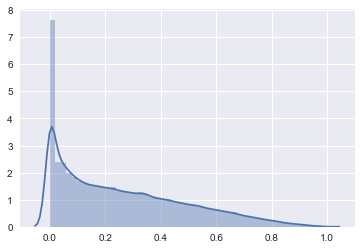

In [33]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [35]:
thresh = .7
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

24109
             precision    recall  f1-score   support

          0     0.9597    0.9620    0.9608    446493
          1     0.2965    0.2837    0.2900     25200

avg / total     0.9242    0.9258    0.9250    471693



In [36]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

In [37]:
with open('../data/model/vote_history/rfc_party2.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'votes_party', predictors=features)